In [1]:
# Copyright (C) 2019  Madeline Wade
#
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 2 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.

In [2]:
# NOTE: HOW TO USE THIS SCRIPT
# This jupyter notebook is meant to be run on your local machine.
# Running the jupyter notebook locally will require some packages to be installed.  Installation and set-up
# instructions can be found at https://dcc.ligo.org/LIGO-G1900392.
# Everywhere you see a TODO below is a spot where you should answer some questions or add some code

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from gwpy.plot import BodePlot
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries
from gwpy.signal.filter_design import fir_from_transfer

In [4]:
# Load in the file containing all of the calibration models.  These are models for the inverse of the sensing function,
# the total acutation function, each stage of the acutation function separately, and the overall response function. 
# As a reminder, the response function is
#     R = (1+G)/C, where G = C*D*A
# G is the open loop gain, C is the sensing function, A is the actuation function, and D are the digital DARM filters.
# TODO: You'll need to modify this line to point to the location of L1DCS_test.npz if it's not in your working directory.
models = np.load("L1DCS_test.npz")
# The models were all calculated at specific frequencies.  Below we pull out this frequency array for plotting later on. 
freqs = models["response_function"][0]
f0 = freqs[0]
df = freqs[1]-freqs[0]
fNyq = freqs[-1]
# The response function was stored as separate real and imaginary parts in the file, so we're just 
# putting it all together as a gwpy FrequencySeries object below.  
# (Sidenote: If you're new to Python, there will be a bit of Python jargon throughout. Apologies! You can just ignore
# most of this jargon.  You should be able to follow along anyway.)
response_function = FrequencySeries(models["response_function"][1] + 1j*models["response_function"][2], f0 = f0, df = df)
# Same as above, but now for the overall acutation function (A)
actuation_function = FrequencySeries(models["act_model"][1] + 1j*models["act_model"][2], f0 = f0, df = df)
# Same as above, but now for the inverse sensing function (1/C)
inv_sensing_function = FrequencySeries(models["invsens_model"][1] + 1j*models["invsens_model"][2], f0 = f0, df = df)

# It will also be useful to look at each stage of the actuation separately, so below we put together FrequencySeries
# objects for the TST, PUM, and UIM stages of the actuation.
uim_actuation_function = FrequencySeries(models["uim_model"][1] + 1j*models["uim_model"][2], f0 = f0, df = df)
pum_actuation_function = FrequencySeries(models["pum_model"][1] + 1j*models["pum_model"][2], f0 = f0, df = df)
tst_actuation_function = FrequencySeries(models["tst_model"][1] + 1j*models["tst_model"][2], f0 = f0, df = df)

<IPython.core.display.Javascript object>


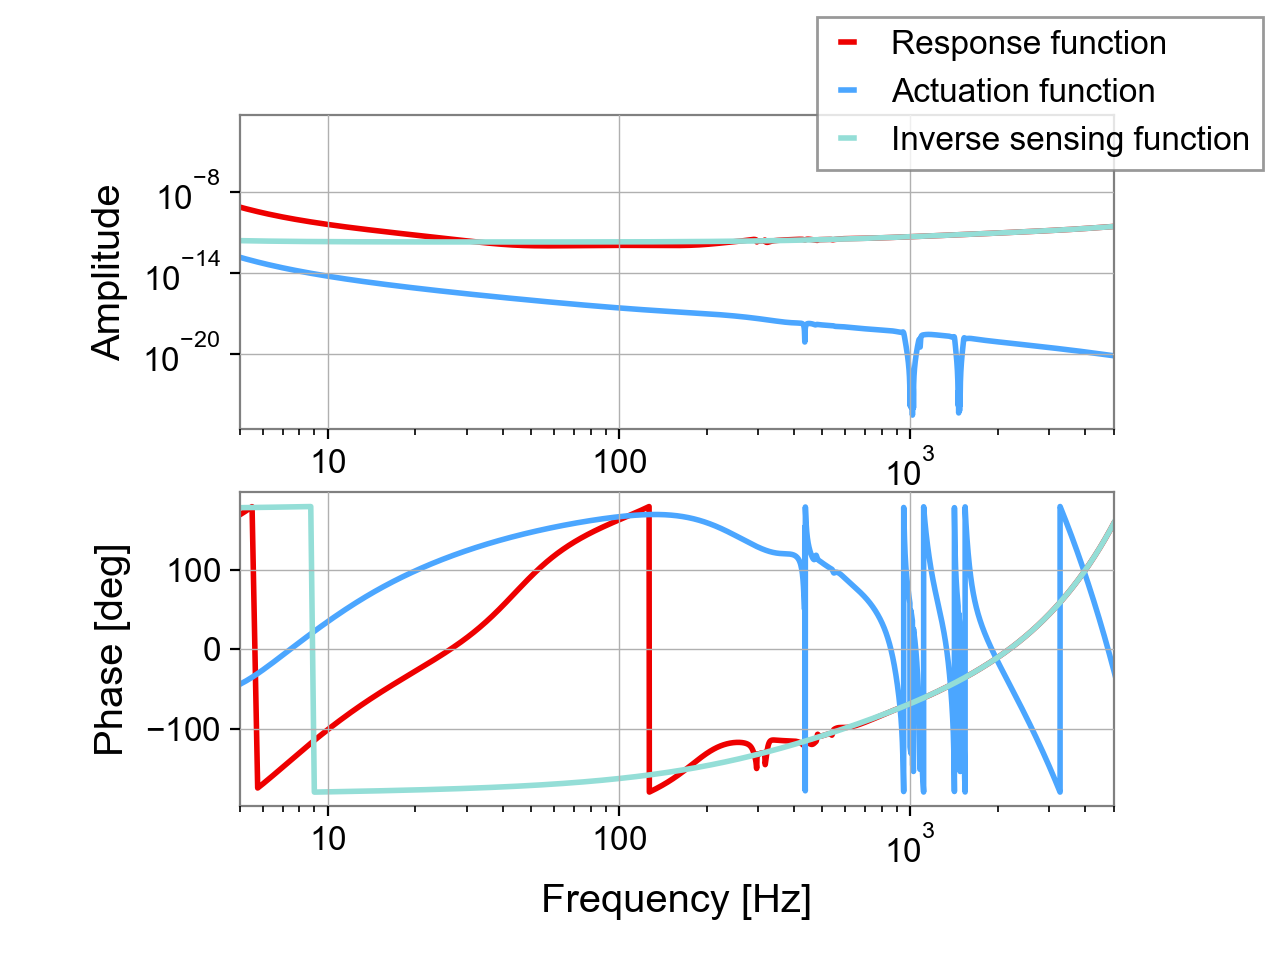

In [5]:
# Let's look at the different components of the calibration
# First, let's make a bode plot of the response function
plot = BodePlot(response_function, frequencies=freqs, dB=False, color='#ee0000', linewidth=2)
plot.add_frequencyseries(actuation_function, dB=False, color='#4ba6ff',linewidth=2)
plot.add_frequencyseries(inv_sensing_function, dB=False, color="#94ded7", linewidth=2)
plot.legend([r"Response function",r"Actuation function",r"Inverse sensing function"])
plot.maxes.set_yscale('log')
plot.paxes.set_yscale('linear')
plot.maxes.set_xlim(5,5000)
plot.paxes.set_xlim(5,5000)
plot.show()

# TODO: Looking at the resulting plot, discuss the following questions:
# 1) At which frequencies (low, mid, high) will the actuation function make its biggest contribution to h(t) reconstruction?
# 2) At which frequencies (low, mid, high) will the inverse sensing function make its biggest contribution to h(t) reconstruction?

<IPython.core.display.Javascript object>


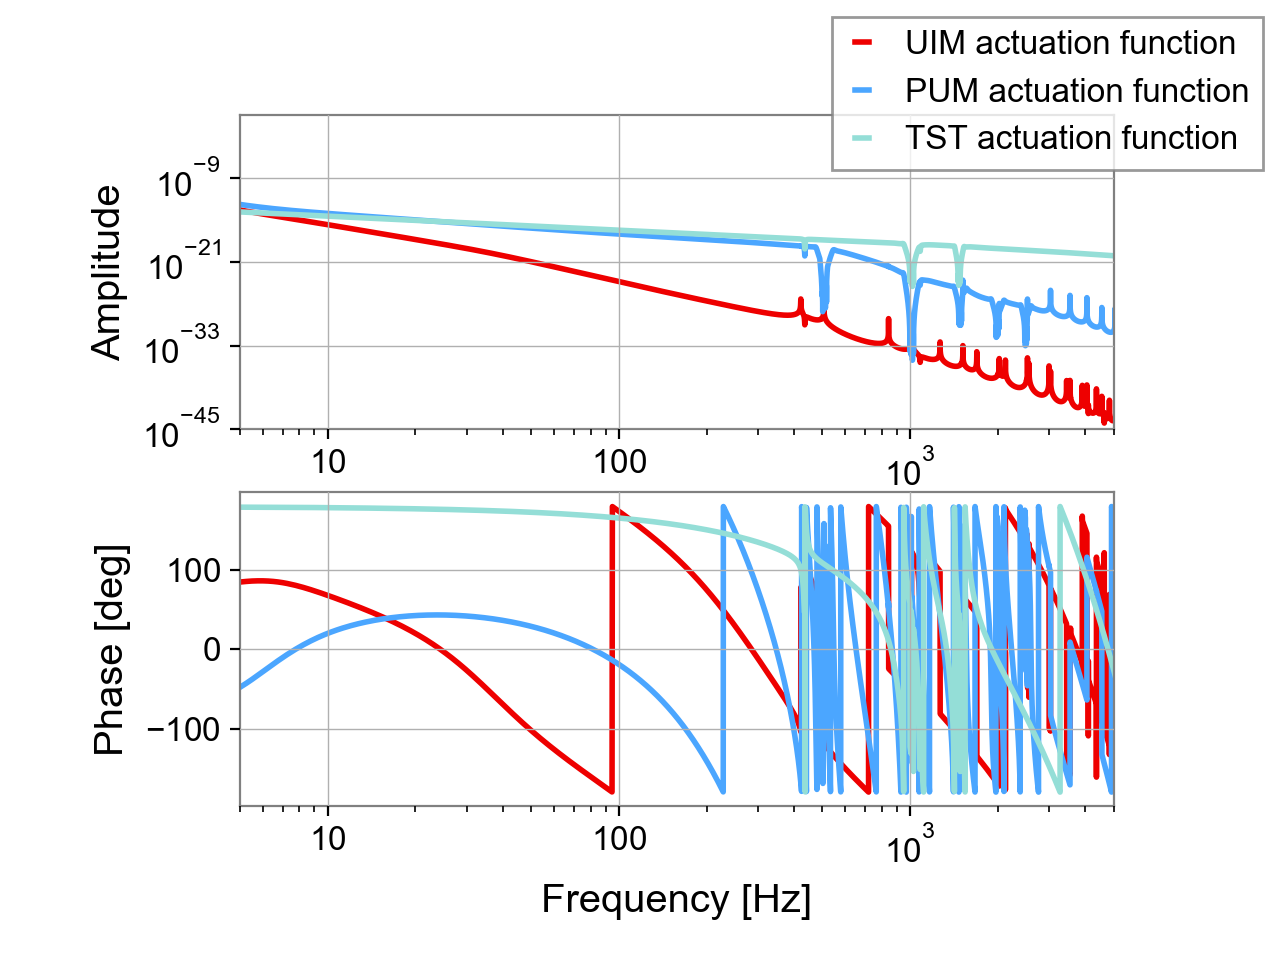

In [6]:
# Now let's take a look at the break down of the actuation chain
plot = BodePlot(uim_actuation_function, frequencies=freqs, dB=False, color='#ee0000', linewidth=2)
plot.add_frequencyseries(pum_actuation_function, dB=False, color='#4ba6ff',linewidth=2)
plot.add_frequencyseries(tst_actuation_function, dB=False, color="#94ded7", linewidth=2)
plot.legend([r"UIM actuation function",r"PUM actuation function",r"TST actuation function"])
plot.maxes.set_yscale('log')
plot.paxes.set_yscale('linear')
plot.maxes.set_xlim(5,5000)
plot.paxes.set_xlim(5,5000)
plot.maxes.set_ylim(1e-45,1)
plot.show()
# TODO: Looking at the resulting plot, discuss the following questions
# 1) Discuss notable differences in the frequency evolution of each stage of the actuation. 
# 2) In theory, if you find that the actuation function contains large uncertainties around 100 Hz after performing
#    some calibration measurements, which stage(s) of the actuation should you focus on for improving this uncertainty?
# 3) In a new cell below, create a plot that zooms in on the Bode plot below from 5 to 30 Hz.  At what frequency does 
#    the TST stage become the most dominant?

In [7]:
# Now we have to make filters out of these functions.  Recall, a filter is an object that modifies time series data
# in a known way to obtain a desired results.  In the frequency domain, this is a simple multiplication of the 
# frequency domain filter with frequency domain data.  In the time domain, this process is done by a convolution of
# the filter with the time domain data.

# Technical sidenote: For this exercise, we will make Finite Impulse Response (FIR) filters. 
# In the calibration, we actually use a combination of Infinite Impulse Response (IIR) filters and FIR filters.
# For details about the different pipelines and why these filter choices were made, please check out one of our publications:
# https://iopscience.iop.org/article/10.1088/1361-6382/aab658

# Before we make a filter out of the frequency domain models of the acutation and inverse sensing functions,
# we need to modify low frequency components to fall to zero.  This is called a highpass filter, since high frequency 
# components are not modified, or are allowed to "pass" through this filter.  The highpass filter is used to avoid 
# modeling the low frequency components (below 9 Hz) of the actuation and inverse sensing.  A very long filter would 
# be required if we tried to model these low frequency components, so by highpass filtering we can create shorter 
# filters with good accuracy.  This means we will NOT be producing accurate strain data below 9 Hz, which is okay.

# We also need to modify the high frequency components of the inverse sensing to fall to zero. This is called a
# lowpass filter, since low frequency components are allowed to "pass" through.
# The high frequency components of the inverse sensing function need to be rolled off because the 
# inverse sensing function blows up at high frequencies, which creates an unphysics filter.

# For this tutorial, we'll do construct high and low pass filters in a really simple way with just half of a 
# Hann window on the magnitudes.  

# High pass filter the actuation and inverse sensing functions below 9 Hz.  
HPcorner_freq = 9 # this is the frequency (in Hz) below which we are rolling off the model components
samples_to_HPcorner = int(HPcorner_freq/df)
hp_hann = np.hanning(samples_to_HPcorner)
hp_hann = hp_hann[:int(samples_to_HPcorner / 2)]
hp_hann = np.concatenate((np.zeros(samples_to_HPcorner - len(hp_hann)), hp_hann)) # We'll actually roll off to zero by about 5 Hz
actuation_function[:samples_to_HPcorner] *= hp_hann**4
inv_sensing_function[:samples_to_HPcorner] *= hp_hann**4

# Low pass filter the inverse sensing function above 6000 Hz
LPcorner_freq = 6000 # this is the frequency (in Hz) above which we are rolling off the model components
samples_to_LPcorner = int((fNyq - LPcorner_freq) / df)
lp_hann = np.hanning(2*samples_to_LPcorner)
lp_hann = lp_hann[-samples_to_LPcorner:]
inv_sensing_function[-samples_to_LPcorner:] *= lp_hann

# We will use a built-in gwpy function to create FIR filters from our actuation and inverse sensing models.
# To read more about the method we actually use in the production calibration tools, see
# https://iopscience.iop.org/article/10.1088/1361-6382/aab658
hoft_sr = 2*fNyq # The sample rate of the data must be twice the Nyquist of the models used to create the filters
dur = 1/df # The total duration of the filter is dictated by the frequency spacing of the models
ntaps = int(hoft_sr*dur) # The number of taps of the FIR filter will be the duration of the filter times the sample rate
actuation_fir = fir_from_transfer(actuation_function, ntaps)
inv_sensing_fir = fir_from_transfer(inv_sensing_function, ntaps)

In [10]:
# First, let's fetch the data. For this step, you'll need to have NDS2 installed or be on a cluster.
# See instructions downloadable from https://dcc.ligo.org/LIGO-G1900392 for how to install NDS2 for this tutorial
# From the gwpy documentation: 
# Note: Access to data using the nds2 client requires a Kerberos authentication ticket. 
# This can be generated from the command-line using kinit:
#       $ kinit albert.einstein@LIGO.ORG
# where albert.einstein should be replaced with your own LIGO.ORG identity. 
# If you don’t have an active kerberos credential at the time you run TimeSeries.get, GWpy will prompt you to create one.
  
# This step will take a few minutes.    
darm_err = TimeSeries.get('L1:CAL-DARM_ERR_DBL_DQ',1235184405,1235184905)
darm_ctrl = TimeSeries.get('L1:CAL-DARM_CTRL_DBL_DQ',1235184405,1235184905)

In [9]:
# TODO: Add in code below that will filter the DARM_ERR and DARM_CTRL data with the appropriate FIR filters that you
# created above.  You can use the built-in convolve function for a gwpy TimeSeries object, i.e.
#          filtered_data = darm_err.convolve(FIR_filter_name)
# Note: If you are unfamiliar with Python classes or methods, that's okay.  The takeaway is that you can filter time
# series data using the syntax above.  In this example, darm_err is the time series data being filtered, filtered_data 
# is the output of the filtering process and FIR_filter_name is the FIR filter to filter with.

# As a reminder, \Delta L_free is contructed by
#  \Delta L_free = (1/C)*darm_err + A*darm_ctrl
# and h(t) = \Delta L_free / L

# res_chain should be the output of filtering the darm_error (or residual) data
res_chain = 
# ctrl_chain should be the output of filtering the darm_ctrl (or control) data
ctrl_chain = 

SyntaxError: invalid syntax (<ipython-input-9-e4de9bc36089>, line 13)

In [ ]:
# TODO: Add in code below that will construct h(t) from your filtered results in the previous cell
L = 3995.1
hoft = 

In [ ]:
# Let's check it out! 
plot = hoft.plot()
ax = plot.gca()
ax.set_ylabel('Gravitational-wave amplitude [strain]')
ax.set_title('LIGO-Livingston strain data')
plot.show()

In [ ]:
# Now let's check out the ASD (Amplitude Spectral Density) of the data you just made
asd = hoft.asd(4, 2, method = "lal_median_mean")
plot = asd.plot()
ax = plot.gca()
ax.set_xlim(10, 5000)
ax.set_ylim(1e-24,1e-18)
plot.show()

In [ ]:
# Let's see what the actual h(t) data from the production calibration pipeline looked like at this time
# This step will take a few minutes.    
hoft_C00 = TimeSeries.get('L1:GDS-CALIB_STRAIN',1235184405,1235184905)

In [ ]:
# Let's see how the ASDs compare
asd = hoft.asd(4, 2, method = "lal_median_mean")
asd_C00 = hoft_C00.asd(4, 2, method = "lal_median_mean")
plot = asd.plot()
ax = plot.gca()
ax.plot(asd_C00)
ax.set_xlim(10, 5000)
ax.set_ylim(1e-24,1e-18)
plot.show()